# Algoritmo de Grover

## Bibliografía
[PennyLane Codemap: Algoritmo de Grover](https://pennylane.ai/codebook/grovers-algorithm/introduction-to-grover-search)

[PennyLane: Tutorial del Algoritmo de Grover](https://pennylane.ai/qml/demos/tutorial_grovers_algorithm)

[Ket-G: El algoritmo de Grover](https://www.youtube.com/watch?v=xPkvB4ECVM4)

[Ket-G: Cálculos Matemáticos de las partes del algoritmo](https://drive.google.com/file/d/1jIw5bhsnkaZgVtfnJ8oqqs1WBo6ybjRw/view)

[Paper original del algoritmo: *A fast quantum mechanical algorithm for database search*](https://arxiv.org/pdf/quant-ph/9605043)

In [1]:
# Indicar si estamos en Google Colab o no (en Juypter, por ejemplo...)
colab = False

# SI ESTÁS EN COLAB -> CAMBIAR Y PONER TU RUTA DE DRIVE HASTA LA CARPETA DE TODOS LOS ARCHIVOS
ruta_base = '/content/drive/My Drive/Quantum/Grover/'

In [ ]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    subruta = 'Imágenes grover/'

In [ ]:
if colab:
    !pip install pennylane

In [1]:
import pennylane as qml # Para implementar los circuitos cuánticos

from pennylane import numpy as np # Para tratar vectores y matrices y operaciones matemáticas

import time # Para hacer cosas con el tiempo (calcular tiempos de ejecución y tal)

import random # Aleatoriedad

from IPython.display import display,Markdown,Latex,Image # Para Latex, enseñar imágenes, etc.

import matplotlib.pyplot as plt # Gráficos

## 1. Explicación teórica

El algoritmo de Grover es un algoritmo cuántico creado en 1996 por el científico Lov K. Grover para **buscar elementos en conjuntos desordenados o sin estructura alguna**. 

Hablando sobre el **esfuerzo necesario** para encontrar dicho elemento en el conjunto, si hay $N$ elementos en total, un **algoritmo clásico** (sea determinístico o probabilístico) tendría que **observar** $\frac{N}{2}$ **elementos en promedio**, por lo que si el tiempo necesario para observar un elemento fuese de un segundo, tardaríamos en media $\frac{N}{2}$ **segundos** en hallar nuestro elemento. Sin embargo, el **Algoritmo de Grover sólo necesita** $\sqrt{N}$ **segundos**. En consecuencia, este algoritmo no sólo mejora a los ya existentes, sino que es el **mejor algoritmo para realizar esta tarea** hasta el día de hoy. 

Imagina que tenemos un *conjunto de* $N$ *elementos*, y *nos interesa uno* en concreto, $|s \rangle$, pero *no sabemos donde está*. Imaginemos también que tenemos un *circuito cuántico* con $n$ cúbits, tal que $2^n = N$. Si todos los cubits están en *superposición* (aplicando una puerta de Hadamard a cada uno), las *amplitudes de cada estado* (incluyendo el que a nosotros nos interesa) es $\frac{1}{\sqrt{N}}$, por lo que las *probabilidades de observar cada estado* son de $\frac{1}{N}$ en todos los casos. Lo podemos visualizar en el siguiente histograma (donde la altura es la amplitud del estado).

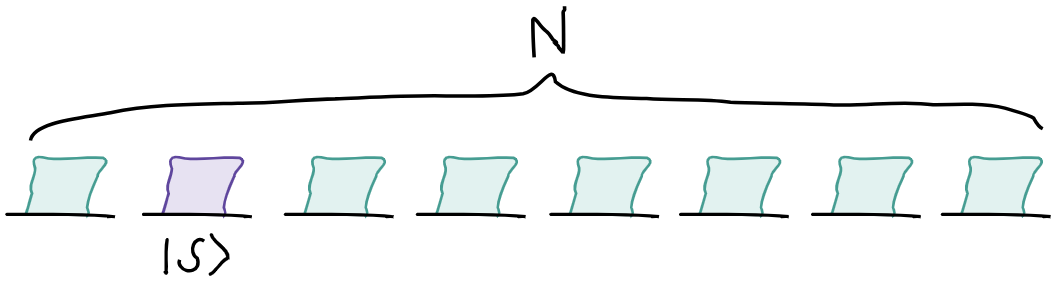

In [11]:
if colab:
    display(Image(filename = ruta_base + subruta + '1_amplitud.png'))
else:
    display(Image(filename='./Imágenes grover/1_amplitud.png'))

Nos gustaría de alguna forma *aumentar la amplitud del estado correspondiente al objeto que queremos hallar*, para que así al medir haya más posibilidades de observarlo (porque queremos encontrarlo). Entonces vamos a hacer lo siguiente: en primer lugar, **aplicar un oráculo** para **cambiar únicamente el signo** de la amplitud del estado que nos interesa. La fórmula de este oráculo asociado a la solución $s$ es:

$$
U_{f,s} = I-2|s\rangle \langle s|
$$

**Nota**: Algebraicamente, al aplicar el oráculo $U_{f,s}$ a un ket $|x\rangle$, $I$ se sustituye por el ket.

Vamos a ver que sólo cambia el signo de $|s\rangle$ y de nada más. Si el elemento que buscamos es $s = 0$ (todo ceros), entonces

$$
U_{f,s}|0\rangle = |0\rangle-2|0\rangle \langle 0|0\rangle = |0\rangle-2|0\rangle·1 = - |0\rangle
$$

Pero por otro lado si $x \neq 0$:
$$
U_{f,s}|x\rangle = |x\rangle-2|0\rangle \langle 0|x\rangle = |x\rangle-2|x\rangle·0 = |x\rangle
$$

En nuestro dibujo se vería algo así:


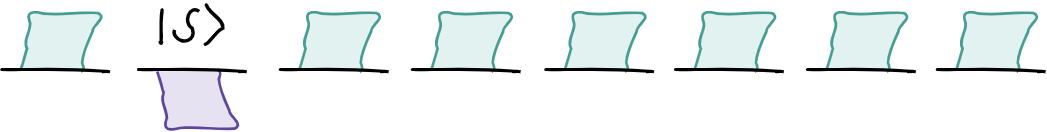

In [3]:
if colab:
    display(Image(filename = ruta_base + subruta + '2_flip.png'))
else:
    display(Image(filename='./Imágenes grover/2_flip.png'))

Pero esto no es suficiente, porque por ahora *sólo hemos cambiado el signo del estado que nos interesa* (su probabilidad de medir es la misma), haciendo que su signo sea negativo. Si aplicásemos de nuevo este operador, volveríamos a la situación inicial. ¿Cómo hacemos entonces para *aumentar la amplitud de nuestro estado* y que para el *resto de estados disminuya*? La **clave** es que las *amplitudes son iguales*, pero el *signo de nuestra solución es el contrario*. Por ello, lo que hacemos es calcular la **diferencia con la superposición uniforme** $|\psi\rangle$ y separarla en dos *componentes*: una parte *proporcional* (parte de arriba de la siguiente imagen) y otra parte *ortogonal* (parte de abajo).

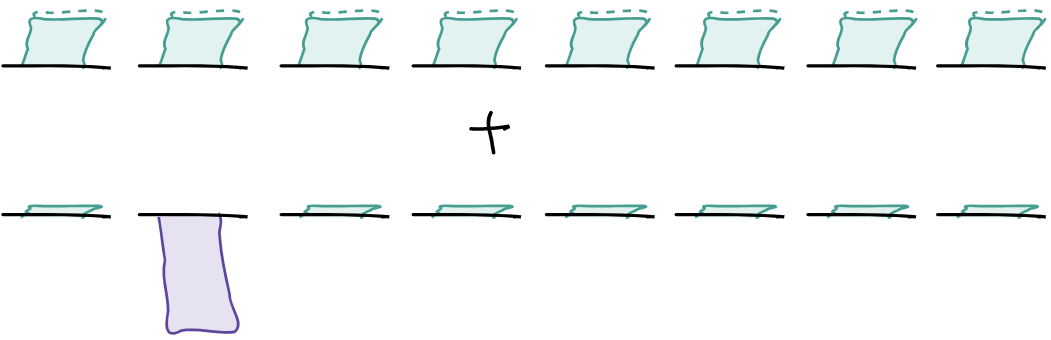

In [5]:
if colab:
    display(Image(filename = ruta_base + subruta + '3_suma.png'))
else:
    display(Image(filename='./Imágenes grover/3_suma.png'))

Luego, necesitamos *invertir el signo de la parte ortogonal*, porque si *sumásemos* esto a la parte proporcional al estado de superposición, veríamos que las *amplitudes de los estados que no nos interesan disminuyen*, pero **la del estado que sí nos interesa aumenta** (se ve en la imagen de abajo). 

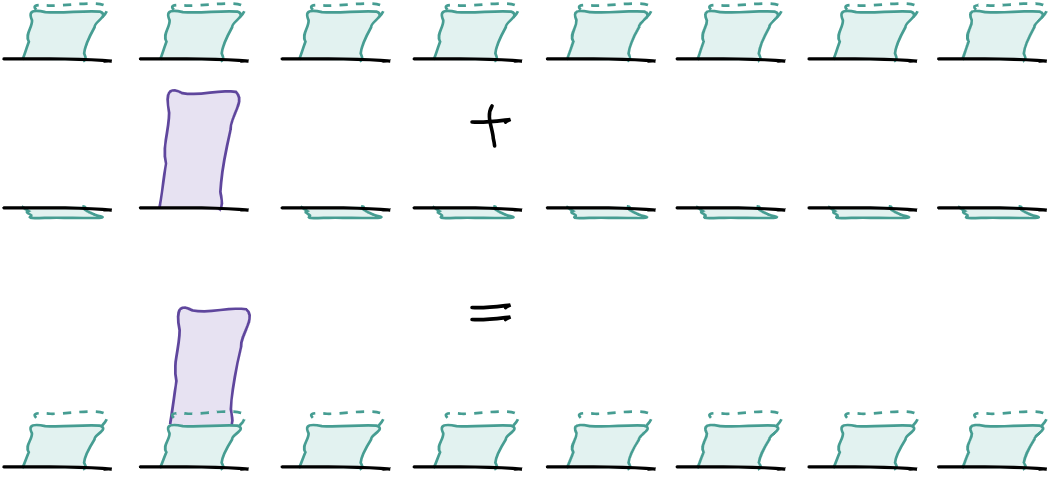

In [6]:
if colab:
    display(Image(filename = ruta_base + subruta + '4_resultado.png'))
else:
    display(Image(filename='./Imágenes grover/4_resultado.png'))

¿Y cómo es ese operador que calcula las partes proporcionales y ortogonal e invierte estas últimas? Se llama **operador de difusión** y es el siguiente:

$$
D = 2|\psi \rangle \langle \psi|-I
$$

Donde $|\psi \rangle$ es el estado de superposición.

**Nota**: De nuevo, algebraicamente, al aplicar $D$ a un ket $|x\rangle$, $I$ se sustituye por el ket.


Si lo de la parte proporcional y ortogonal al estado de superposición no te ha quedado claro, puedes pensar que todo esto es equivalente a hacer una *reflexión sobre la media*. Es decir, primero calcula la *media de las amplitudes actuales* y calcula la *diferencia* entre la *amplitud de cada estado con la media*. Luego *cambia el signo de las diferencias* (de forma que para el estado que nos interesa obtenemos una amplitud positiva y para el resto negativa) y *las sumamos a las amplitudes originales* (antes de aplicar el oráculo). El resultado es que **la solución que nos interesa obtiene una amplitud mayor y el resto de soluciones ven sus amplitudes disminuidas**. Este proceso se refleja en la siguiente imagen.

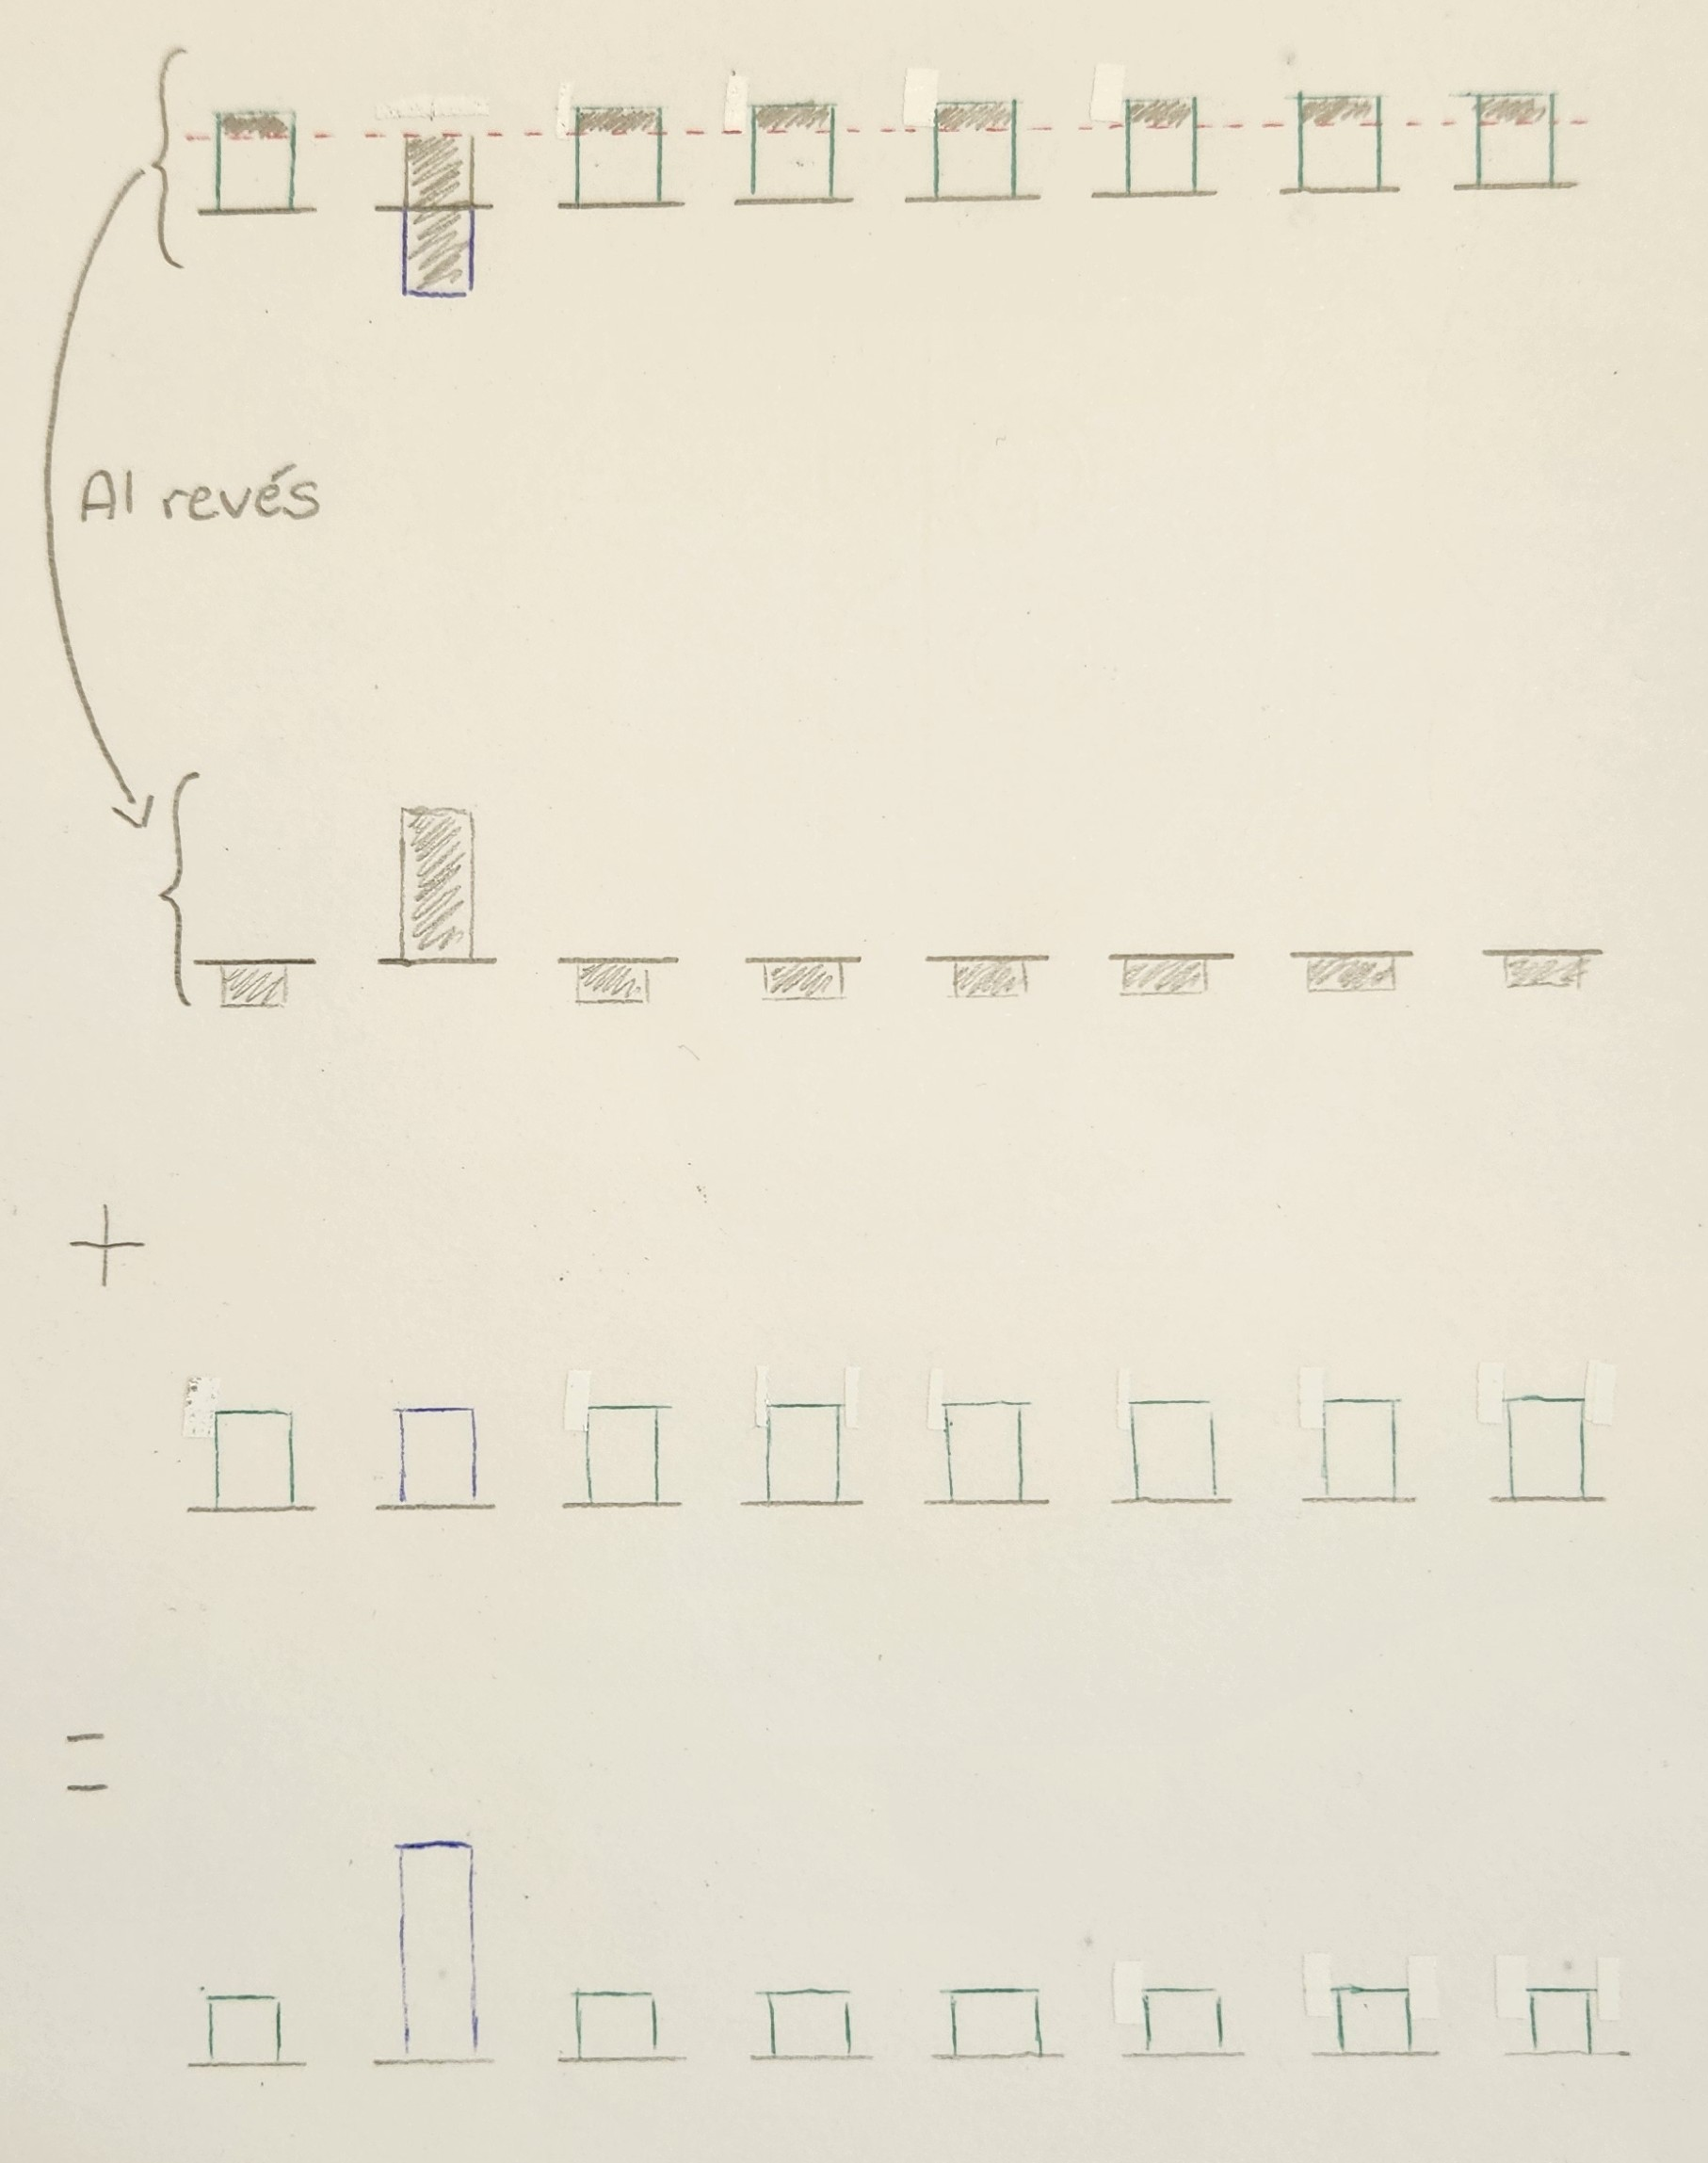

In [7]:
if colab:
    display(Image(filename = ruta_base + subruta + '6_reflexion.png'))
else:
    display(Image(filename='./Imágenes grover/6_reflexion.png'))

Además, estos dos pasos (oráculo y operador de difusión) se pueden **repetir** varias veces, con el fin de *aumentar la amplitud de nuestro estado* y *disminuir las del resto de soluciones*. Las siguientes imágenes representan una segunda iteración del algoritmo.

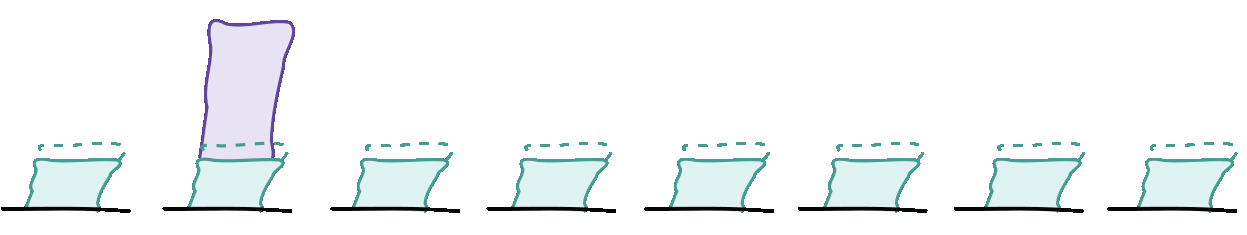

-------------------------------------------------------------------------------------------------------------------------------------------------------


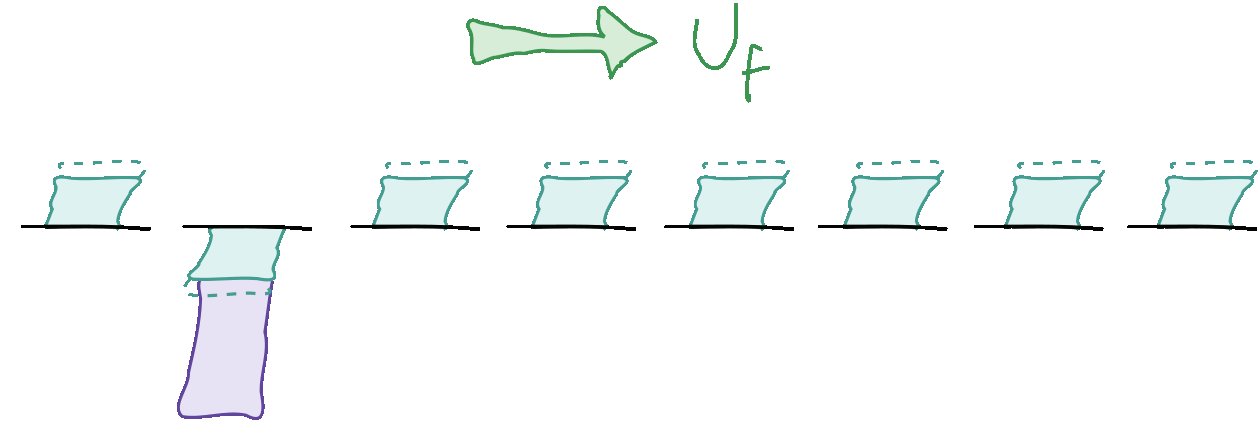

-------------------------------------------------------------------------------------------------------------------------------------------------------


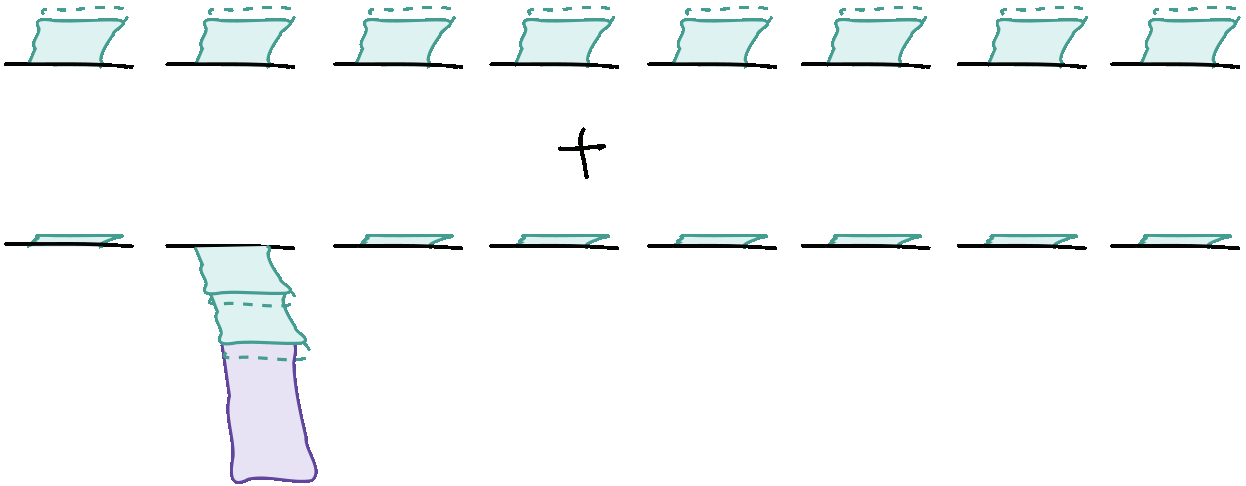

-------------------------------------------------------------------------------------------------------------------------------------------------------


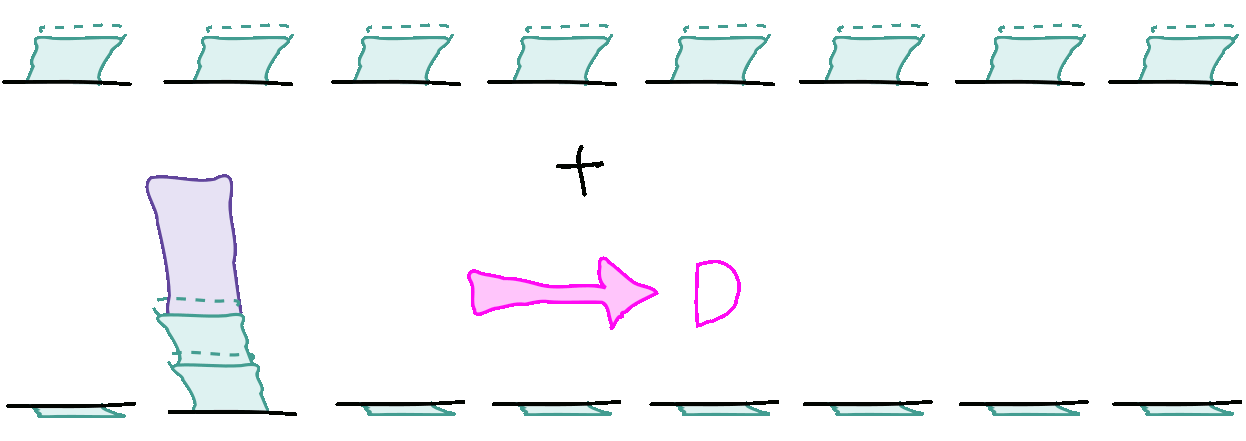

-------------------------------------------------------------------------------------------------------------------------------------------------------


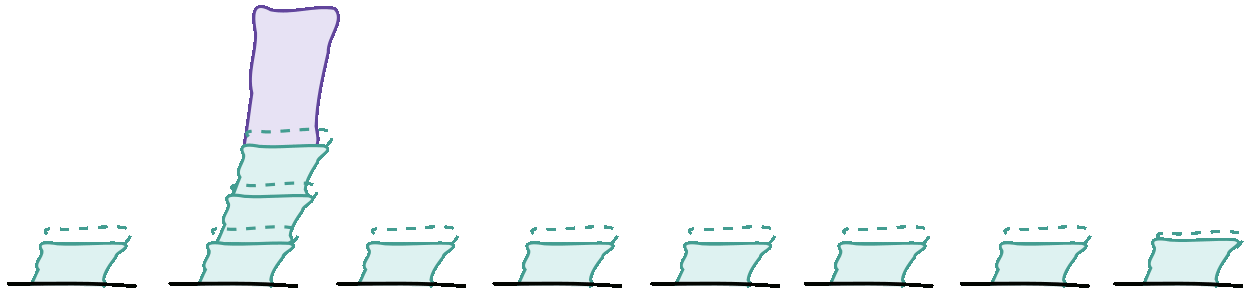

In [22]:
if colab:
    display(Image(filename = ruta_base + subruta + '5_gif_a.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename = ruta_base + subruta + '5_gif_b.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename = ruta_base + subruta + '5_gif_c.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename = ruta_base + subruta + '5_gif_d.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename = ruta_base + subruta + '5_gif_e.png'))
else:
    display(Image(filename='./Imágenes grover/5_gif_a.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename='./Imágenes grover/5_gif_b.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename='./Imágenes grover/5_gif_c.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename='./Imágenes grover/5_gif_d.png'))
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
    display(Image(filename='./Imágenes grover/5_gif_e.png'))

La combinación $G = DU_{f,s}$ se llama **Operador de Grover**, y el algoritmo de Grover basicamente consiste en poner los cubits en *superposición* para luego aplicar este *operador* un número determinado de veces y finalmente *medir* la salida... ¿Y **cuántas veces aplicamos el operador** exactamente? Si $N$ es el número de elementos totales de nuestro conjunto, se ha demostrado que el número de veces que tendremos que usar el operador es:

$$
n_{iter} \approx \frac{\pi}{4} \sqrt{N} \approx 0.79 \sqrt{N}
$$

Es decir, probar con los números enteros adyacentes a $S$ o directamente sustituir por uno de ellos.

## 2. Circuitos asociados al operador de Grover e implementación en Pennylane

Una vez entendido ya la idea general del algoritmo, vamos a aprender a cómo crear el circuito cuántico relacionado y cómo implementarlo en PennyLane.

### 2.1 Cúbit auxiliar

Hemos explicado anteriormente que el oráculo *invierte la amplitud del estado* $|s\rangle$ *que queremos encontrar*. Esto es equivalente a *añadir una fase* igual a $-1$ cuando actúa sobre nuestro estado y no hacer nada en caso contrario. 

Esto se parece a un *operador de control* que se activa cuando ve el estado que justo queremos buscar en los $n$ cubits. Pero claro, si el estado que buscamos es por ejemplo el $|0\rangle$, y la puerta justo ve que estamos en ese estado (porque desde el cúbit $1$ hasta el $n$ están en el estado $0$), entonces los $n$ cubits que tenemos ejecutan la operación controlada... ¿Pero *cuál es el cúbit sobre el cual actúan* si todos los cubits de nuestro circuito son de control? ¿Cómo almacenamos el resultado?

La solución que nos queda es añadir un **cúbit auxiliar** para que ahí se guarde la fase. A partir de ahora llamaremos a los $n$ cubits originales **registro de consulta**, donde se guardará la solución a nuestra consulta o búsqueda. Si hubiera más de un cúbit auxiliar, los llamaríamos **registro auxiliar**.

Vamos a ver cómo implementar la parte inicial de nuestro algoritmo, el oráculo y el operador de difusión teniendo en cuenta el registro auxiliar. 

### 2.2 Parte inicial

Se ha mencionado anteriormente que partimos de un estado de superposición de los cubits. Entonces, a los cubits del **registro de consulta** se les aplica una **puerta de Walsh-Hadamard** (una puerta de Hadamard a todos los cubits). En cambio, al **cúbit o registro auxiliar** se les aplica una puerta $X$ y después la **Hadamard**. 

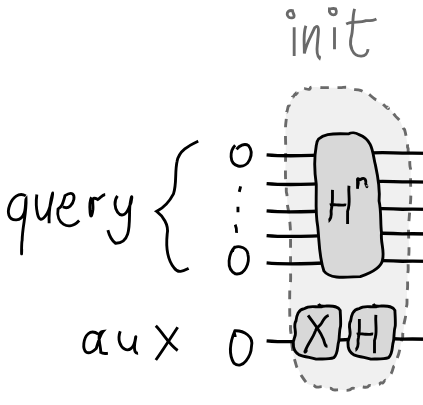

In [3]:
if colab:
    display(Image(filename = ruta_base + subruta + '7_inicio.png'))
else:
    display(Image(filename='./Imágenes grover/7_inicio.png'))

### 2.3 Oráculo

El circuito asociado a nuestro oráculo es una puerta $C^{(n)}NOT$ cuyos cubits de *control* son los que forman el *registro de consulta* y que *actúa* sobre el *registro auxiliar*. Se activa sólo cuando el registro de consulta recibe justo el estado que estamos buscando. 

Por ejemplo, si tenemos 5 cubits de consulta y uno auxiliar, y estamos buscando el estado $01011$, la puerta sólo se activará si el primer y tercer cúbit son $0$ y el resto $1$. 

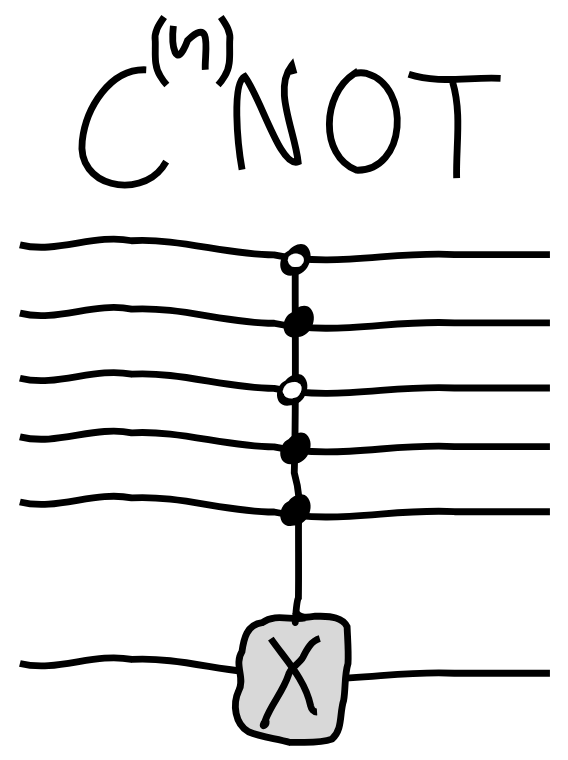

In [4]:
if colab:
    display(Image(filename = ruta_base + subruta + '8_cnot.png'))
else:
    display(Image(filename='./Imágenes grover/8_cnot.png'))

### 2.4 Operador de Difusión

Ahora tenemos una situación ligeramente diferente, porque tenemos la *superposición uniforme* en la fórmula y no el estado que buscamos en base computacional. Entonces lo que hacemos es aplicar una puerta de **Walsh-Hadamard** en el registro de consulta, luego una **puerta** $C^{(n)}NOT$ como en el oráculo el cual se activa si recibe $|0...0\rangle$ **para todos los casos** (teniendo también en cuenta el cúbit o registro auxiliar) y en último lugar otra puerta de **Walsh-Hadamard**.

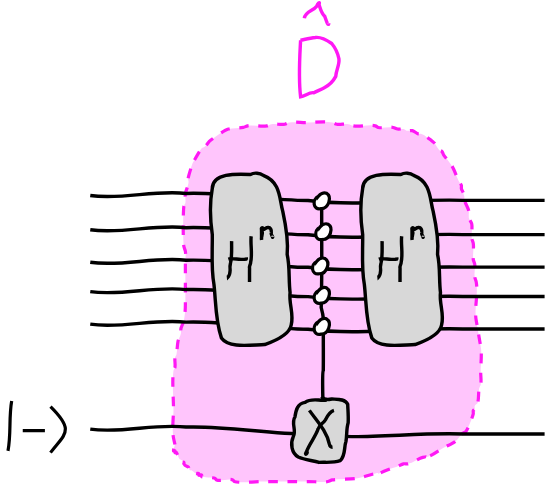

In [5]:
if colab:
    display(Image(filename = ruta_base + subruta + '9_difusion.png'))
else:
    display(Image(filename='./Imágenes grover/9_difusion.png'))

## 3. Algoritmo de Grover con múltiples soluciones

Hasta ahora sólo hemos considerado el caso en el que teníamos que encontrar un único elemento en un conjunto desordenado con $2^n = N$ elementos... Pero ¿y si nos bastase con encontrar **un elemento de un subconjunto de** $M$ **elementos (**subconjunto $S$**) que nos interesa**? Pues el algoritmo de Grover admite una variante que permite solucionar este problema. 

El primer paso es igual al anterior, aplicar una puerta de **Walsh-Hadamard** al *registro de consulta* (una puerta de Hadamard para cada cúbit) y una puerta $X$ y una puerta de **Hadamard** para cada cúbit del *registro auxiliar*. 

Después, aplicamos el **oráculo**, que en este caso es el oráculo **multi-solución**, y la fórmula es:

$$
U_{f,s} = I - \sum_{s \in S} 2|s\rangle \langle s|
$$

Su circuito cuántico asociado es un conjunto de puertas $C^{(n)}NOT$, **una por cada solución de nuestro subconjunto**.

Y por último, el **operador de difusión** es exactamente igual al caso con una solución. 

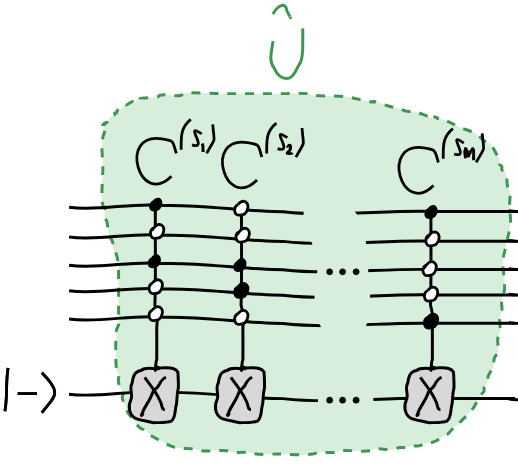

In [6]:
if colab:
    display(Image(filename = ruta_base + subruta + '10_varias_cnot.png'))
else:
    display(Image(filename='./Imágenes grover/10_varias_cnot.png'))

Además, si hay en total $2^n=N$ elementos y hay $M$ soluciones válidas, entonces el número de veces que tenemos que repetir el operador de Grover es:

$$
n_{iter} \approx \frac{\pi}{4}\sqrt{\frac{N}{M}}
$$

## 4. Implementación 

Vamos a estudiar diferentes casos para aprender la implementación del Algoritmo de Grover en `Pennylane` y para descubrir todo su potencial. 

### 4.1 Visualización de efectos de puertas del circuito 

En primer lugar, vamos a observar cómo funciona cada parte del circuito. 

El primer experimento que vamos a probar es a crear un circuito de dos cubits (más el auxiliar) al cual aplicamos la fase inicial del algoritmo de Grover. Como simplemente aplicamos una puerta de Welsh-Hadamard, no sorprende que la probabilidad de observar cada estado sea de $\frac{1}{4}$ y las amplitudes $\frac{1}{2}$.

In [83]:
n_bits = 2
query_register = list(range(n_bits))
aux = [n_bits]
all_wires = query_register + aux
dev = qml.device("default.qubit", wires=all_wires)

# Walsh - Hadamard
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

# Circuito
@qml.qnode(dev)
def circuit():

    # Implementamos la fase inicial del algoritmo de Grover    
    
    # Qubit auxiliar
    qml.X(aux)
    qml.Hadamard(wires=aux)
    
    # Registro de consulta
    equal_superposition(query_register)
    
    return qml.probs(wires = query_register)  # obtenemos amplitudes

# Ejecutar
results = circuit()

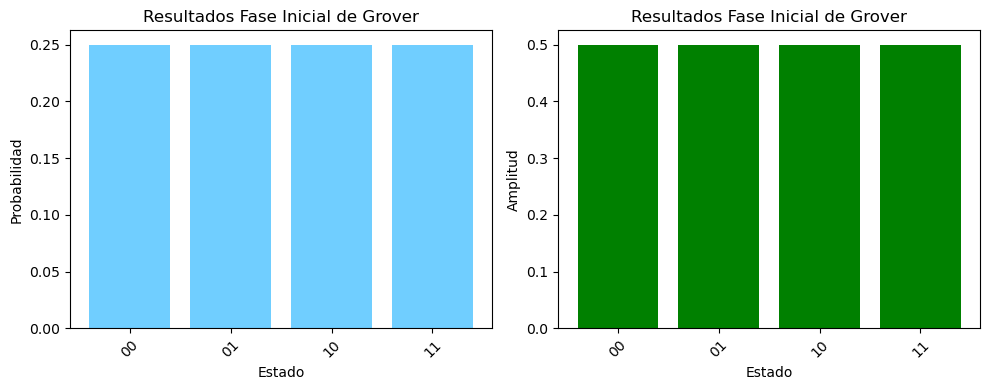

In [84]:
bit_strings = [f"{x:0{n_bits}b}" for x in range(2**n_bits)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(bit_strings, results, color = "#70CEFF")
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_xlabel("Estado")
ax[0].set_ylabel("Probabilidad")
ax[0].set_title("Resultados Fase Inicial de Grover")


ax[1].bar(bit_strings, np.sqrt(results), color = "g")
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_xlabel("Estado")
ax[1].set_ylabel("Amplitud")
ax[1].set_title("Resultados Fase Inicial de Grover")

plt.tight_layout()
plt.show()

Ahora vamos a ver la acción del oráculo. Vamos a imaginar que el estado que nos interesa es el $|0...0\rangle$.

**Nota:** con este circuito conseguimos que la amplitud del estado $|0...0\rangle$ sea $-0.5$, pero como no podemos devolver la amplitud de sólo nuestro registro de consulta (tendríamos que devolver todo y las probabilidades y amplitudes no son las mismas), damos la vuelta a mano a la amplitud de nuestro estado en la gráfica de amplitudes. 

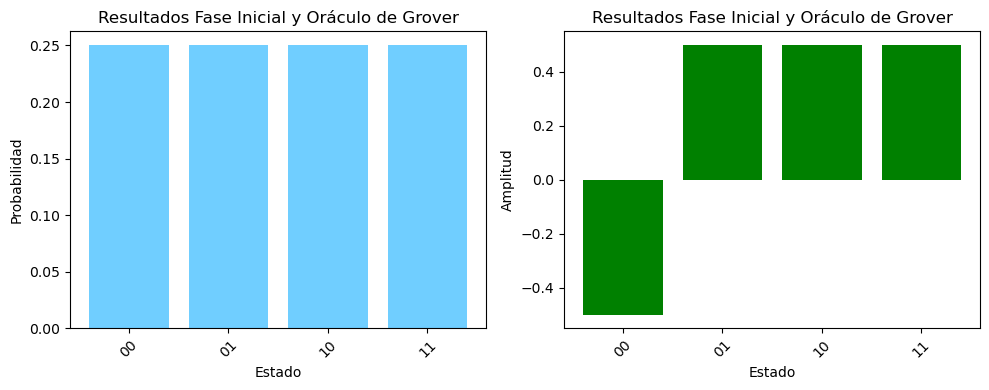

In [76]:
n_bits = 2
query_register = list(range(n_bits))
aux = [n_bits]
all_wires = query_register + aux
dev = qml.device("default.qubit", wires=all_wires)

omega = [0, 0]

# Walsh - Hadamard
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

# Oráculo: 
def oracle(wires, combo):
    """Implementa el oráculo con una puerta multicontrolada

    Args:
        wires (list): Cubits a los que aplicar la puerta multicontrolada (todos los cubits)
        combo (list): Lista de cubits que representa nuestro estado
    """

    qml.MultiControlledX(wires = wires, control_values = combo)

@qml.qnode(dev)
def circuit(omega):

    # Implementamos la fase inicial del Algoritmo de Grover
    
    # Qubit auxiliar
    qml.X(aux)
    qml.Hadamard(wires=aux)
    
    # Registro de consulta
    equal_superposition(query_register)

    # Oráculo
    oracle(all_wires, omega)
    
    return qml.probs(wires = query_register)

results = circuit(omega)

bit_strings = [f"{x:0{n_bits}b}" for x in range(2**n_bits)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].bar(bit_strings, results, color = "#70CEFF")
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].set_xlabel("Estado")
ax[0].set_ylabel("Probabilidad")
ax[0].set_title("Resultados Fase Inicial y Oráculo de Grover")

amplitudes = np.sqrt(results)
estado = int(''.join([str(digito) for digito in omega]), 2)
amplitudes[estado] = -1 * amplitudes[estado]

ax[1].bar(bit_strings, amplitudes, color = "g")
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].set_xlabel("Estado")
ax[1].set_ylabel("Amplitud")
ax[1].set_title("Resultados Fase Inicial y Oráculo de Grover")

plt.tight_layout()
plt.show()

Ahora, vamos a probar a introducir también el operador de difusión, ¡por lo que tendríamos ya el operador de Grover totalmente construido!

Y nos podemos preguntar, ¿cuántas iteraciones hay que ejecutar el operador de Grover? Como solo hay una solución que nos valga y hay cuatro posibles estados: 

$$
S \approx \frac{\pi}{4} \sqrt{4} = \frac{\pi}{2} = 1.5707
$$

Es decir, que con una o dos iteraciones nos vale (en este ejemplo de juguete, una iteración nos devuelve justo una probabilidad de 1 para nuestro estado, pero si lo ejecutamos dos veces, obtenemos el estado de superposición, tal y como se ve en la gráfica).

Numero de iteraciones:  1.5707963267948966


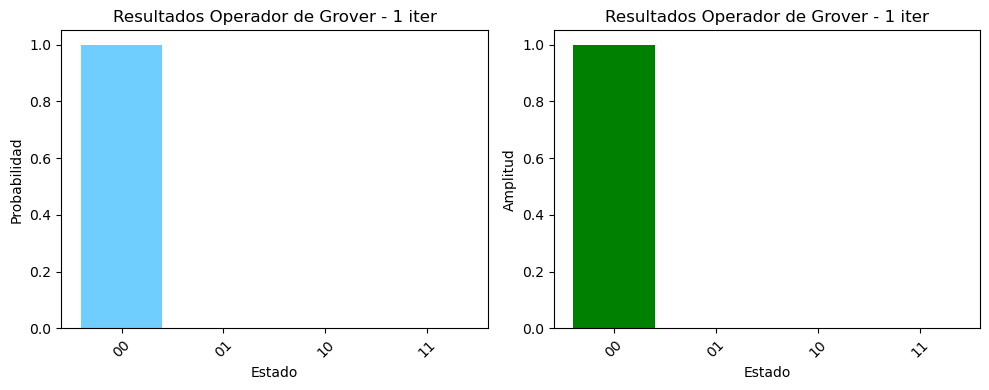

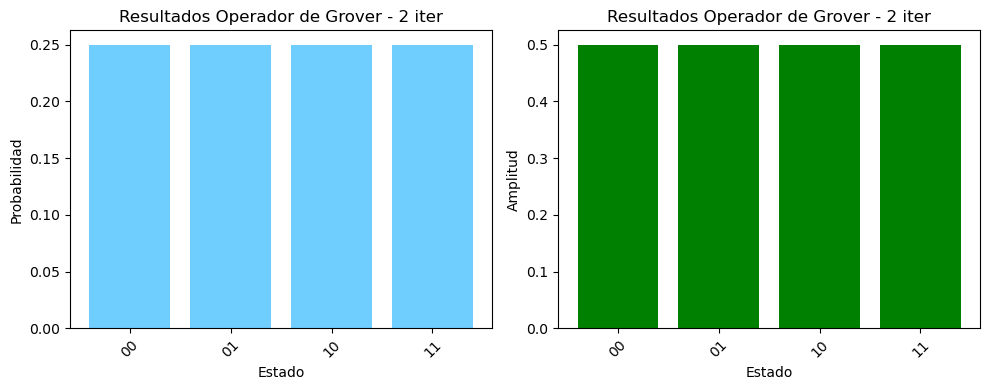

In [87]:
n_bits = 2
query_register = list(range(n_bits))
aux = [n_bits]
all_wires = query_register + aux
dev = qml.device("default.qubit", wires=all_wires)

omega = [0, 0]

# Walsh - Hadamard
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

# Oráculo
def oracle(wires, combo):
    """Implementa el oráculo con una puerta multicontrolada

    Args:
        wires (list): Cubits a los que aplicar la puerta multicontrolada (todos los cubits)
        combo (list): Lista de bits que representa el estado que nos interesa 
    """

    qml.MultiControlledX(wires = wires, control_values = combo)

# Difusión
def diffusion(query_register, aux):
    """Implementa el operador de difusión usando la puerta Walsh-Hadamard dos veces y en medio una puerta multicontrolada
    
    Args:
        query_register (list): Lista con los cubits del registro de consulta
        aux (list): Lista con el/los cubit(s) auxiliar(es)
    
    """
    equal_superposition(query_register)
    qml.MultiControlledX(
        wires = query_register + aux,
        control_values= [0] * len(query_register),
    )
    equal_superposition(query_register)

@qml.qnode(dev)
def circuit(omega, num_iter):

    # Implementamos la fase inicial del Algoritmo de Grover
    
    # Qubit auxiliar
    qml.X(aux)
    qml.Hadamard(wires = aux)
    
    # Registro de consulta
    equal_superposition(query_register)

    for _ in range(num_iter):

        # Oráculo
        oracle(all_wires, omega)
    
        # Difusión
        diffusion(query_register, aux)
    
    return qml.probs(wires = query_register)

# Calculamos el número de veces que ejecutamos el Operador de Grover
iteraciones = np.sqrt(2**n_bits)*np.pi/4
print("Numero de iteraciones: ",iteraciones) #1 ó 2
lista_iter = [int(iteraciones), int(iteraciones) + 1]

for num_iter in lista_iter:
    results = circuit(omega, num_iter)
    
    bit_strings = [f"{x:0{n_bits}b}" for x in range(2**n_bits)]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].bar(bit_strings, results, color = "#70CEFF")
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[0].set_xlabel("Estado")
    ax[0].set_ylabel("Probabilidad")
    ax[0].set_title("Resultados Operador de Grover - "+str(num_iter)+" iter")
    
    amplitudes = np.sqrt(results)
    
    ax[1].bar(bit_strings, amplitudes, color = "g")
    ax[1].tick_params(axis='x', labelrotation=45)
    ax[1].set_xlabel("Estado")
    ax[1].set_ylabel("Amplitud")
    ax[1].set_title("Resultados Operador de Grover - "+str(num_iter)+" iter")
    
    plt.tight_layout()
    plt.show()

Ahora que hemos visto los efectos de cada parte del algoritmo, vamos a pensar en si tenemos $M$ soluciones válidas dentro de nuestro conjunto de $N$ elementos. Se modifica el oráculo para tener en cuenta todas las posibles soluciones, pero el resto permanece igual.

En este ejemplo, si consideramos dos soluciones válidas en un conjunto de $2^5 = 32$ elementos, el número de iteraciones es:

$$
S \approx \frac{\pi}{4} \sqrt{\frac{N}{M}} = \frac{\pi}{4} \sqrt{\frac{32}{2}} = \pi
$$

Vamos a ejecutar el algoritmo de Grover y luego vamos a buscar los elementos a mano; compararemos los tiempos de ejecución. 

Numero de iteraciones:  3
[Grover] Encontrado en:  0.024793148040771484  s


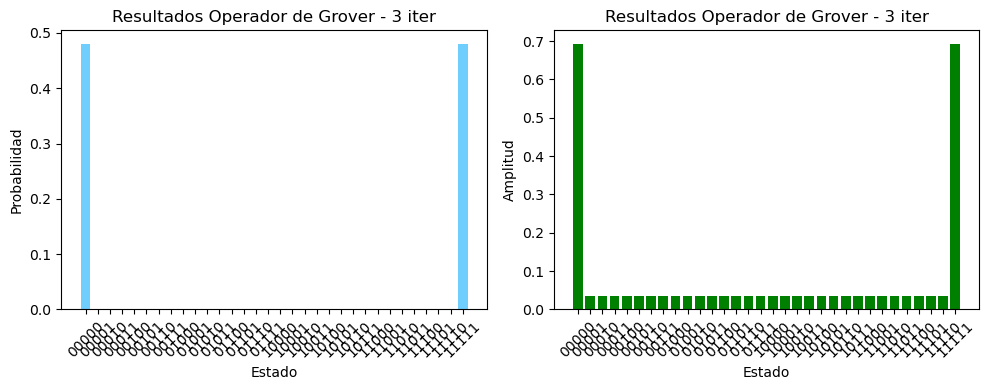

In [2]:
n_bits = 5
query_register = list(range(n_bits))
aux = [n_bits]
all_wires = query_register + aux
dev = qml.device("default.qubit", wires=all_wires)

omega = [[0]*n_bits, [1]*n_bits]

# Walsh - Hadamard
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

# Oráculo
def oracle(wires, combos):
    """Implementa el oráculo con una puerta multicontrolada

    Args:
        wires (list): Cubits a los que aplicar la puerta multicontrolada (todos los cubits)
        combo (list(list)): Lista de listas de bits que representan los estados que nos interesan
    """
    for combo in combos:
        qml.MultiControlledX(wires = wires, control_values = combo)

# Difusión
def diffusion(query_register, aux):
    """Implementa el operador de difusión usando la puerta Walsh-Hadamard dos veces y en medio una puerta multicontrolada
    
    Args:
        query_register (list): Lista con los cubits del registro de consulta
        aux (list): Lista con el/los cubit(s) auxiliar(es)
    
    """
    equal_superposition(query_register)
    qml.MultiControlledX(
        wires = query_register + aux,
        control_values= [0] * len(query_register),
    )
    equal_superposition(query_register)

@qml.qnode(dev)
def circuit(omega, num_iter):

    # Implementamos la fase inicial del Algoritmo de Grover
    
    # Qubit auxiliar
    qml.X(aux)
    qml.Hadamard(wires = aux)
    
    # Registro de consulta
    equal_superposition(query_register)

    for _ in range(num_iter):

        # Oráculo
        oracle(all_wires, omega)
    
        # Difusión
        diffusion(query_register, aux)
    
    return qml.probs(wires = query_register)

# Calculamos el número de veces que ejecutamos el Operador de Grover
num_iter = int(np.sqrt(2**n_bits/len(omega))*np.pi/4)
print("Numero de iteraciones: ",num_iter) 

start_time = time.time()
results = circuit(omega, num_iter)
elapsed = time.time() - start_time

print("[Grover] Encontrado en: ",elapsed," s")

if n_bits < 7:
    bit_strings = [f"{x:0{n_bits}b}" for x in range(2**n_bits)]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].bar(bit_strings, results, color = "#70CEFF")
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[0].set_xlabel("Estado")
    ax[0].set_ylabel("Probabilidad")
    ax[0].set_title("Resultados Operador de Grover - "+str(num_iter)+" iter")
    
    amplitudes = np.sqrt(results)
    
    ax[1].bar(bit_strings, amplitudes, color = "g")
    ax[1].tick_params(axis='x', labelrotation=45)
    ax[1].set_xlabel("Estado")
    ax[1].set_ylabel("Amplitud")
    ax[1].set_title("Resultados Operador de Grover - "+str(num_iter)+" iter")
    
    plt.tight_layout()
    plt.show()
    
else:
    def bin_to_dec(bin_list):
        return int("".join(str(b) for b in bin_list), 2)

    for state in omega:
        idx = bin_to_dec(state)
        print(f"Probabilidad del estado {state}: {results[idx]}")

In [7]:
omega_str = [[str(digito) for digito in lista] for lista in omega]
target = [''.join(lista) for lista in omega_str]
target_index = [int(numero, 2) for numero in target]

def classical_search(target_index, N):
    piezas = list(range(N))
    random.shuffle(piezas)  # simulamos que el orden no es conocido
    start_time = time.time()
    for i, pieza in enumerate(piezas):
        if pieza in target_index:
            elapsed = time.time() - start_time
            return elapsed
            
tiempos = []
num_intentos = 200
for i in range(num_intentos):
    tiempos.append(classical_search(target_index, 2**n_bits))

print("[Clásico] Encontrado en media en: ",np.mean(tiempos)," s")

[Clásico] Encontrado en media en:  0.0  s


Ahora vamos a comparar los tiempos de ejecución con el algoritmo de Grover y el clásico para distintos tamaños de conjuntos.

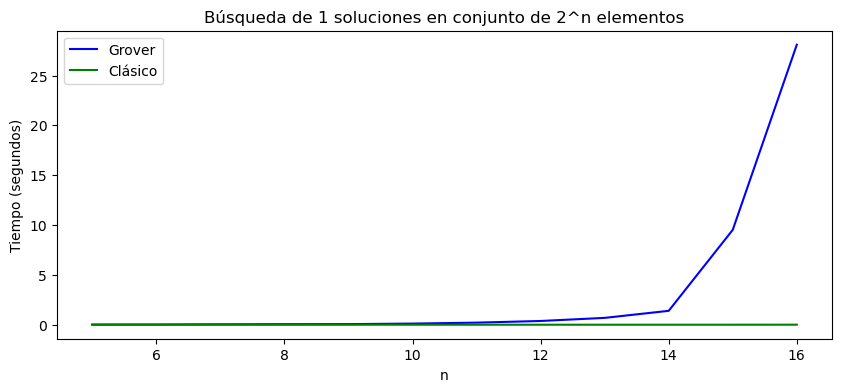

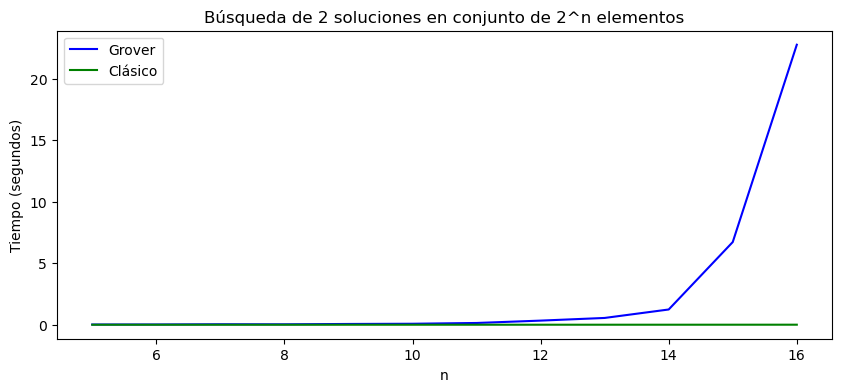

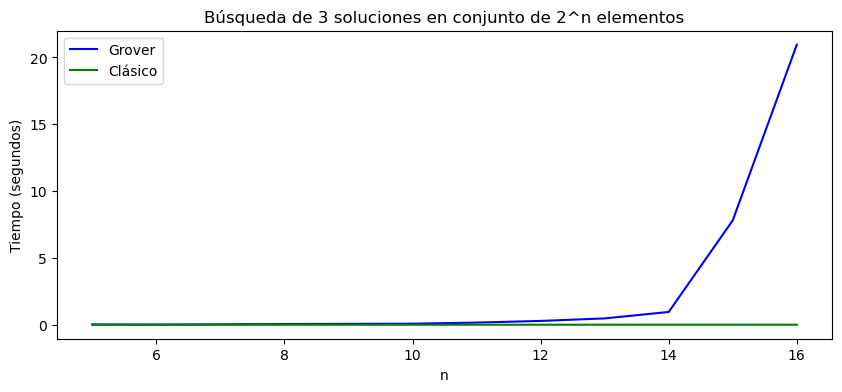

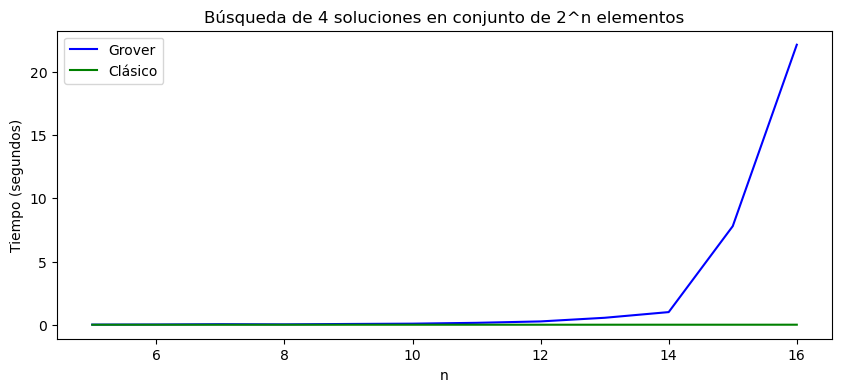

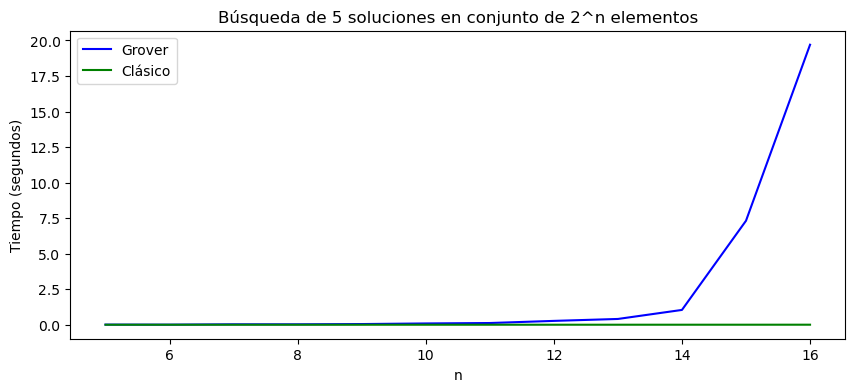

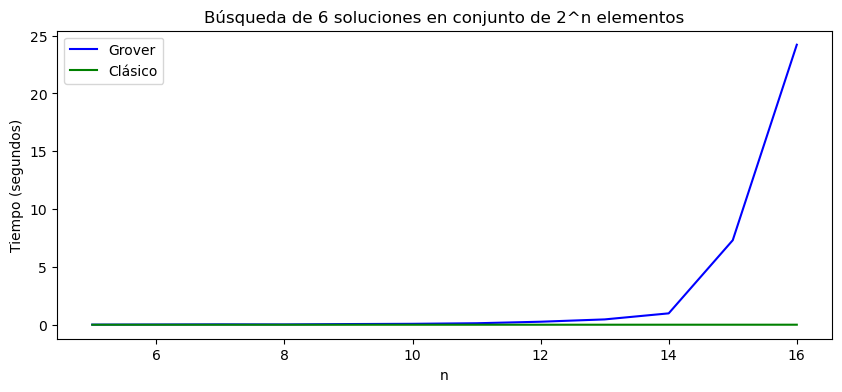

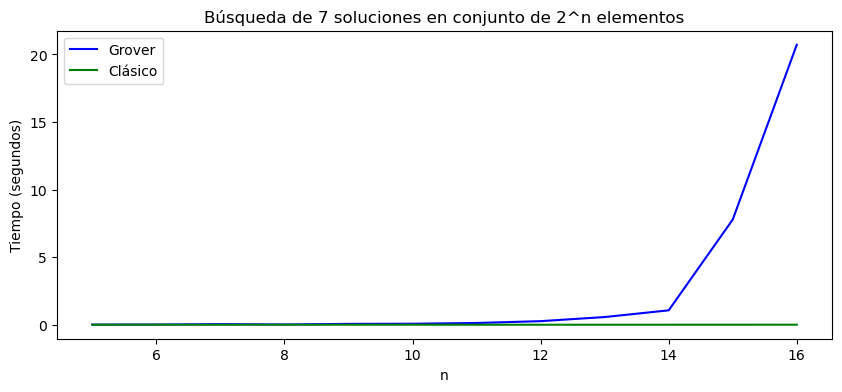

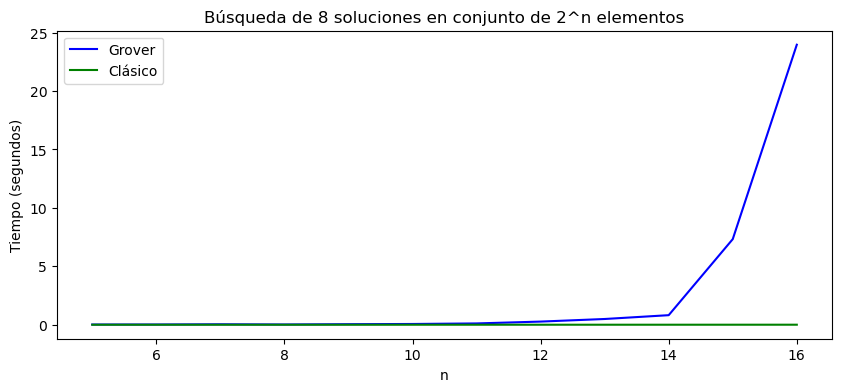

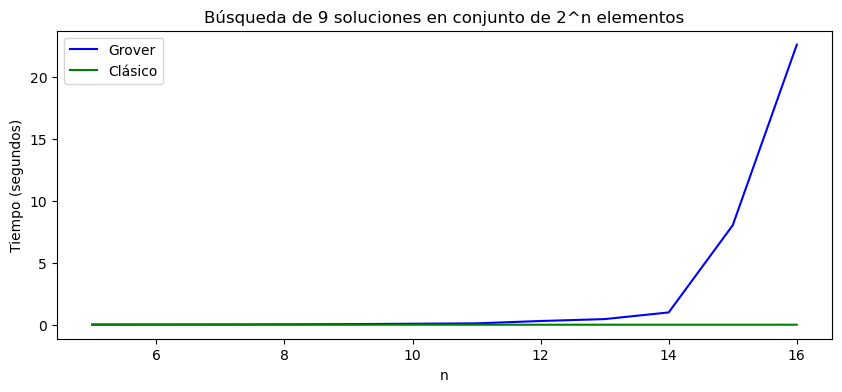

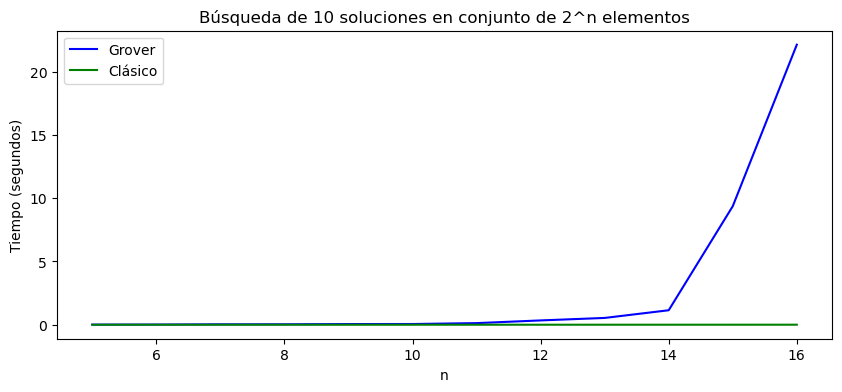

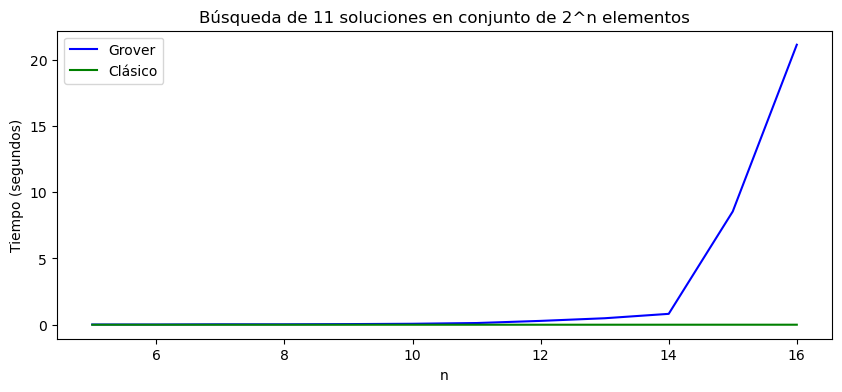

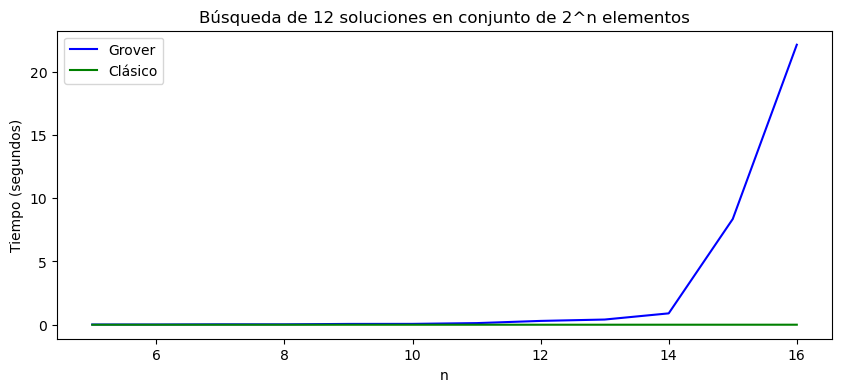

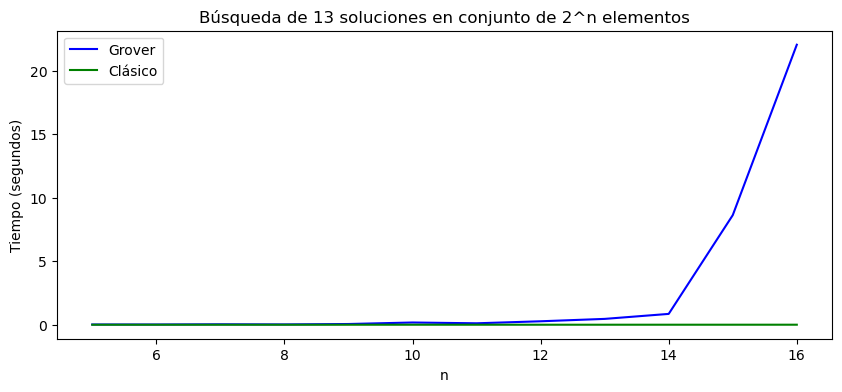

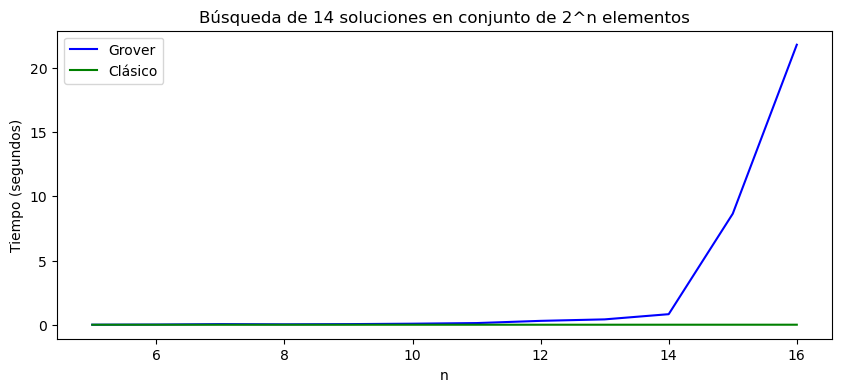

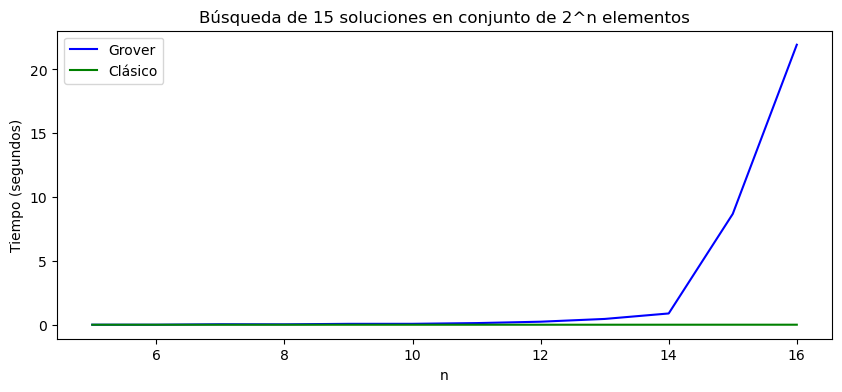

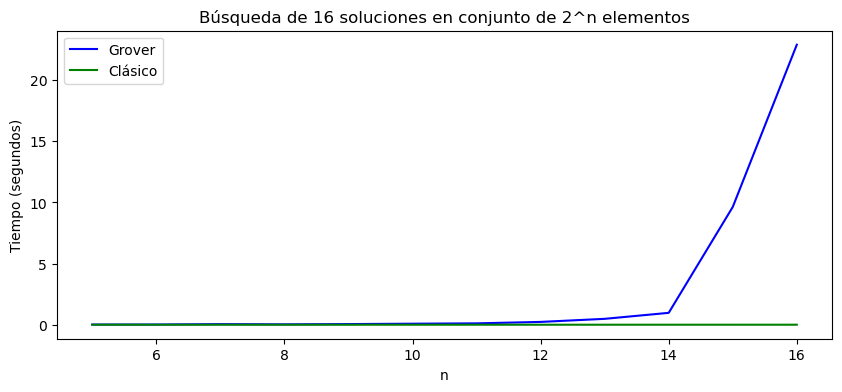

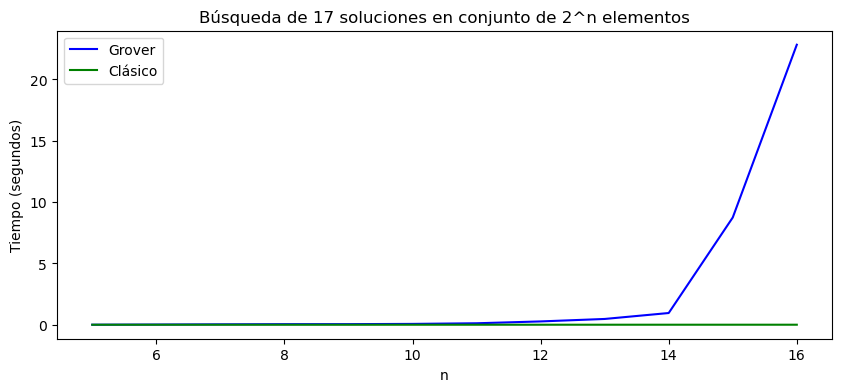

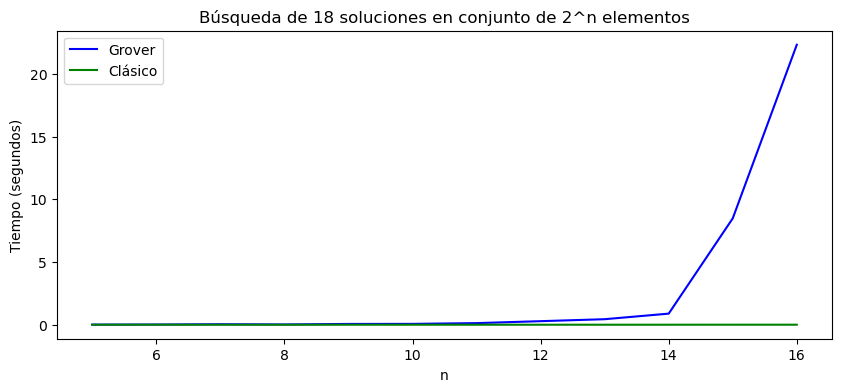

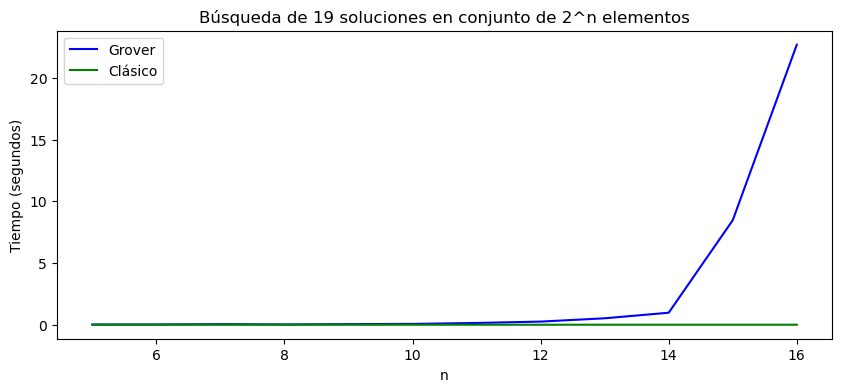

In [22]:
lim_inf = 5
lim_sup = 17

def random_binary(n_bits):
    numero = []
    for _ in range(n_bits):
        numero.append(random.randint(0,1))
    return numero

min_sol = 1
max_sol = 20

for num_sol in range(min_sol, max_sol):
    
    tiempos_grover = []
    tiempos_clasico = []
    
    for n_bits in range(lim_inf, lim_sup):
        query_register = list(range(n_bits))
        aux = [n_bits]
        all_wires = query_register + aux
        dev = qml.device("default.qubit", wires=all_wires)

        omega = []
        while len(omega)<num_sol:
            sol = random_binary(n_bits)
            if sol not in omega:
                omega.append(sol)
        
        #omega = [[0]*n_bits, [1]*n_bits]
        
        @qml.qnode(dev)
        def circuit(omega, num_iter):
        
            # Implementamos la fase inicial del Algoritmo de Grover
            
            # Qubit auxiliar
            qml.X(aux)
            qml.Hadamard(wires = aux)
            
            # Registro de consulta
            equal_superposition(query_register)
        
            for _ in range(num_iter):
        
                # Oráculo
                oracle(all_wires, omega)
            
                # Difusión
                diffusion(query_register, aux)
            
            return qml.probs(wires = query_register)
        
        # Calculamos el número de veces que ejecutamos el Operador de Grover
        num_iter = int(np.sqrt(2**n_bits/len(omega))*np.pi/4)
        
        start_time = time.time()
        results = circuit(omega, num_iter)
        tiempos_grover.append(time.time() - start_time)
        
        omega_str = [[str(digito) for digito in lista] for lista in omega]
        target = [''.join(lista) for lista in omega_str]
        target_index = [int(numero, 2) for numero in target]
        
        tiempos = []
        num_intentos = 200
        for i in range(num_intentos):
            tiempos.append(classical_search(target_index, 2**n_bits))
        
        tiempos_clasico.append(np.mean(tiempos))
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    ax.plot(range(lim_inf, lim_sup), tiempos_grover, "b", label = "Grover")
    ax.plot(range(lim_inf, lim_sup), tiempos_clasico, "g", label = "Clásico")
    ax.set_xlabel("n")
    ax.set_ylabel("Tiempo (segundos)")
    ax.legend(loc = 'upper left')
    ax.set_title("Búsqueda de "+str(len(omega))+" soluciones en conjunto de 2^n elementos")
    plt.show()

Se observa que hasta $n=14$, los dos algoritmos son relativamente parecidos; sin embargo, después empieza a escalar exponencialmente. Si se consiguiese más capacidad de procesamiento (bien sea con un mejor procesador de un ordenador o conectando ordenadores en paralelo), podrían obtenerse mejores resultados para el algoritmo de Grover. Además, habría que estudiar si en un ordenador cuántico de verdad el algoritmo funciona de una mejor forma. 

## 5. ¿Cuándo empieza a escalar el buscador clásico?

Text(0.5, 1.0, 'Búsqueda lineal')

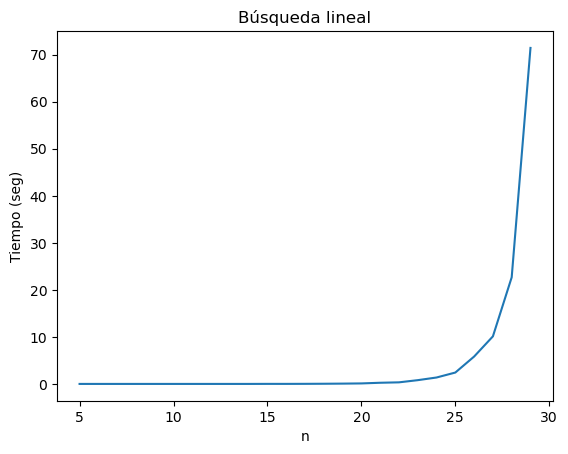

In [7]:
# Calcular tiempo para recorrer una vez toda la lista y dividir entre 2
tiempos = []

n_min = 5
n_max = 30

for n in range(n_min, n_max):
    lista_numeros = list(range(2**n))
    tonto = 0
    inicio = time.time()
    for elemento in lista_numeros:
        tonto = tonto + 1
    tiempos.append((time.time()-inicio)/2)

fig, ax = plt.subplots()
ax.plot(range(n_min,n_max), tiempos)
ax.set_xlabel("n")
ax.set_ylabel("Tiempo (seg)")
ax.set_title("Búsqueda lineal")